# Lineal Regression a+b(x)
# Numpy and Pandas 

# 1. Trainind data set 
# 2. Validation data set
# 3. Test data set


In [146]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from sklearn import metrics 
dat = yf.Ticker("NVDA")
df = yf.download(["NVDA"], period='12mo', interval='1d') # Por hora o por minuto, o por dia 
df[('Prev Close', 'NVDA')] = df[('Close', 'NVDA')].shift(1)  # Shifted by 1 to use previous day's close to predict today's
df.dropna(inplace=True)  # Remove rows with NaN values
df.tail()
# df['Prev Close']

# dat.calendar
# dat.analyst_price_targets
# dat.quarterly_income_stmt
# dat.history(period='1mo')
# dat.option_chain(dat.options[0]).calls




[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,Prev Close
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,,
2025-03-19,117.519997,120.449997,115.680000,117.269997,273426200,115.430000
2025-03-20,118.529999,120.199997,116.470001,116.550003,248829700,117.519997
2025-03-21,117.699997,117.989998,115.419998,116.940002,266498500,118.529999
2025-03-24,121.410004,122.220001,119.339996,119.879997,228452500,117.699997
2025-03-25,120.915001,121.290001,118.919998,120.567497,143734790,121.410004


In [147]:
import pyodbc 


try:
    with pyodbc.connect(r'DRIVER={ODBC Driver 17 for SQL Server};SERVER=localhost;DATABASE=stock_market;Trusted_Connection=yes;')  as conn: # Si se pierde la conexion, cierra la sesion
        cursor = conn.cursor()
        # Method 2: Using itertuples() - faster than iterrows()
        for row in df.itertuples():
            print(f"Index: {row.Index}")
            print(row)
            print(f"Price: {row[0]}")
            print("-" * 30)
            
            data = {
                'ticker': 'NVDA',
                'date': row.Index,
                'price': row[1],
                'close': row[2],
                'high': row[3],
                'low': row[4],
                'open': row[5],
                'volume': row[6]
            }
            print(data)
            cursor.execute("""
                INSERT INTO StockPrices (Ticker, "Date", "Price", "Close", "High", "Low", "Open", Volume)
                SELECT ?, ?, ?, ?, ?, ?, ?, ?
                WHERE NOT EXISTS (
                    SELECT 1 FROM StockPrices 
                    WHERE Ticker = ? AND Date = ?
                )
            """, 
            data['ticker'], data['date'], data['price'], data['close'], data['high'],
            data['low'], data['open'], data['volume'],
            data['ticker'], data['date'])
        
            if cursor.rowcount > 0:
                print("New record inserted successfully")
            else:
                print("Record already exists - no insertion made")
            
except pyodbc.Error as e:
    print(f"Database error: {e}")



Index: 2024-03-26 00:00:00
Pandas(Index=Timestamp('2024-03-26 00:00:00'), _1=92.53058624267578, _2=96.34333614885402, _3=92.47160751849903, _4=95.8195062336972, _5=513648000, _6=94.97078704833984)
Price: 2024-03-26 00:00:00
------------------------------
{'ticker': 'NVDA', 'date': Timestamp('2024-03-26 00:00:00'), 'price': 92.53058624267578, 'close': 96.34333614885402, 'high': 92.47160751849903, 'low': 95.8195062336972, 'open': 513648000, 'volume': 94.97078704833984}
Record already exists - no insertion made
Index: 2024-03-27 00:00:00
Pandas(Index=Timestamp('2024-03-27 00:00:00'), _1=90.22035217285156, _2=93.20936779906054, _3=89.09372349939157, _4=93.08141149546424, _5=586067000, _6=92.53058624267578)
Price: 2024-03-27 00:00:00
------------------------------
{'ticker': 'NVDA', 'date': Timestamp('2024-03-27 00:00:00'), 'price': 90.22035217285156, 'close': 93.20936779906054, 'high': 89.09372349939157, 'low': 93.08141149546424, 'open': 586067000, 'volume': 92.53058624267578}
Record alrea

In [148]:
x = df["Prev Close"]
y = df["Close"]

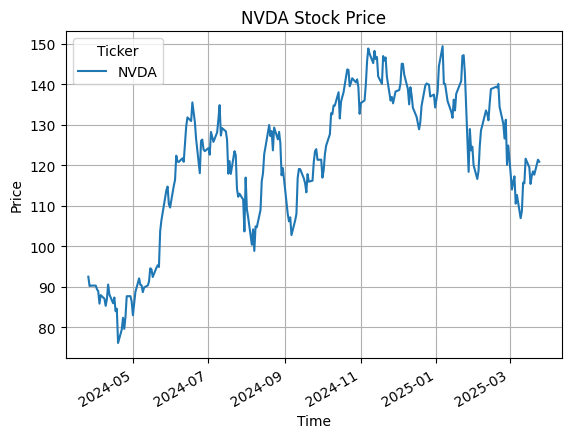

In [149]:
df["Close"].plot()
plt.title("NVDA Stock Price")
plt.ylabel("Price")
plt.xlabel("Time")
plt.grid(which="major")

In [150]:
def CreateTrainTestSet(x, y):
    features = x
    target = y

    data_len = x.shape[0]

    print("Historical data length: ", data_len)

    train_split = int(data_len * 0.88) # 88% training data
    print("Training data len: ", train_split)
    val_split = train_split + int(data_len * 0.1) # 10%
    print("Validation Set Len", val_split)
    X_train, X_val, X_test = features[:train_split], features[train_split:val_split], features[val_split:]
    Y_train, Y_val, Y_test = target[:train_split], target[train_split:val_split], target[val_split:]

    return X_train, X_val, X_test, Y_train, Y_val, Y_test


X_train, X_val, X_test, Y_train, Y_val, Y_test = CreateTrainTestSet(x, y)

Historical data length:  250
Training data len:  220
Validation Set Len 245


In [151]:
from sklearn.linear_model import LinearRegression

model = LinearRegression() 
model.fit(X_train, Y_train)

LinearRegression()

In [152]:
print("Performance (R^2):" , model.score(X_train, Y_train))

Performance (R^2): 0.951467404227658


In [153]:
def get_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np. array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) *100

In [154]:
Y_train_pred = model.predict(X_train)
Y_val_pred = model.predict(X_val)
Y_test_pred = model.predict(X_test)


In [155]:
# print("Training R-squared: ",round(metrics.r2_score(Y_train,Y_train_pred),2))
# print("Training Explained Variation: ",round(metrics.explained_variance_score(Y_train,Y_train_pred),2))
# print('Training MAPE:', round(get_mape(Y_train,Y_train_pred), 2)) 
# print('Training Mean Squared Error:', round(metrics.mean_squared_error(Y_train,Y_train_pred), 2)) 
# print("Training RMSE: ",round(np.sqrt(metrics.mean_squared_error(Y_train,Y_train_pred)),2))
# print("Training MAE: ",round(metrics.mean_absolute_error(Y_train,Y_train_pred),2))

# print(' ')

# print("Validation R-squared: ",round(metrics.r2_score(Y_val,Y_val_pred),2))
# print("Validation Explained Variation: ",round(metrics.explained_variance_score(Y_val,Y_val_pred),2))
# print('Validation MAPE:', round(get_mape(Y_val,Y_val_pred), 2)) 
# print('Validation Mean Squared Error:', round(metrics.mean_squared_error(Y_train,Y_train_pred), 2)) 
# print("Validation RMSE: ",round(np.sqrt(metrics.mean_squared_error(Y_val,Y_val_pred)),2))
# print("Validation MAE: ",round(metrics.mean_absolute_error(Y_val,Y_val_pred),2))

# print(' ')

# print("Test R-squared: ",round(metrics.r2_score(Y_test,Y_test_pred),2))
# print("Test Explained Variation: ",round(metrics.explained_variance_score(Y_test,Y_test_pred),2))
# print('Test MAPE:', round(get_mape(Y_test,Y_test_pred), 2)) 
# print('Test Mean Squared Error:', round(metrics.mean_squared_error(Y_test,Y_test_pred), 2)) 
# print("Test RMSE: ",round(np.sqrt(metrics.mean_squared_error(Y_test,Y_test_pred)),2))
# print("Test MAE: ",round(metrics.mean_absolute_error(Y_test,Y_test_pred),2))

In [156]:
# df_pred = pd.DataFrame(Y_val.values, columns=['Actual'], index=Y_val.index)
# df_pred['Predicted'] = Y_val_pred
# df_pred = df_pred.reset_index()
# df_pred.loc[:, 'Date'] = pd.to_datetime(df_pred['Date'],format='%Y-%m-%d')
# df_pred

# Predicting tomorrows Stock Price

In [157]:
# Y_test.loc[-1] = Y_test.tail(1)
# df[('Prev Close', 'NVDA')] = df[('Close', 'NVDA')].shift(1)  # Shifted by 1 to use previous day's close to predict today's
# df.dropna(inplace=True)  # Remove rows with NaN values
# tomorrow['Date'] = pd.date_range('3/14/2025', periods = 1, freq ='D')
# tomorrow = pd.concat([Y_test, pd.DataFrame(
#     [{'Date': pd.Timestamp.today()}])]) # .reset_index(drop=True)
import datetime

tomorrow = Y_test.tail(1)
tomorrowsDate = datetime.date.today() + datetime.timedelta(days=1)
tomorrow.index = pd.MultiIndex.from_tuples([('NVDA', tomorrowsDate)], names=['Ticker', 'Date'])
tomorrowsPrice = model.predict(tomorrow)
df_pred = pd.DataFrame(tomorrow.values, columns=["Predicted"], index=tomorrow.index)
df_pred['Predicted'] = tomorrowsPrice
df_pred = df_pred.reset_index()
df_pred.loc[:, 'Date'] = pd.to_datetime(df_pred['Date'],format='%Y-%m-%d')
df_pred
print(tomorrow)


Ticker                   NVDA
Ticker Date                  
NVDA   2025-03-26  120.915001


In [158]:
# Read the pickle file
global predictions_df
try:
    predictions_df = pd.read_pickle('predictions.pkl')
    print(predictions_df)
    # Check if date already exists
    # Check if '2025-03-26' exists in the 'Ticker Date' level
    date_to_check = pd.to_datetime('2025-03-26')
    exists = date_to_check in pd.to_datetime(predictions_df.index.get_level_values('Date'))
    predictions_df.index.get_level_values('Date')
    if not exists:
        predictions_df = pd.concat([predictions_df, tomorrow])
        predictions_df.to_pickle('predictions.pkl')
except FileNotFoundError:
    print("predictions.pkl not found")
    print("No predictions found")
    tomorrow.to_pickle('predictions.pkl')
    print(tomorrow)



Ticker                   NVDA
Ticker Date                  
NVDA   2025-03-26  120.178596


In [163]:
import pyodbc 


with pyodbc.connect(r'DRIVER={ODBC Driver 17 for SQL Server};SERVER=localhost;DATABASE=stock_market;Trusted_Connection=yes;')  as conn: # Si se pierde la conexion, cierra la sesion
    cursor = conn.cursor()
    # Method 2: Using itertuples() - faster than iterrows()
    for row in predictions_df.itertuples():
        print(f"Index: {row.Index}")
        print(row)
        print(f"Price: {row[0]}")
        print("-" * 30)
        [print(val) for val in row]
        data = (
            'NVDA',
            row.Index[1],
            row[1]
        )
        cursor.execute("""
            INSERT INTO StockPrices (Ticker, "Date", Prediction)
            SELECT ?, ?, ?
        """, 
        data)
    
        if cursor.rowcount > 0:
            print("New record inserted successfully")
        else:
            print("Record already exists - no insertion made")

Index: ('NVDA', datetime.date(2025, 3, 26))
Pandas(Index=('NVDA', datetime.date(2025, 3, 26)), NVDA=120.17859649658203)
Price: ('NVDA', datetime.date(2025, 3, 26))
------------------------------
('NVDA', datetime.date(2025, 3, 26))
120.17859649658203
New record inserted successfully


> Get latest date 
# Agregar la fecha 
# Agregar 24 horas
- 2025-03-14

In [ ]:
# API Twitter X

# Selenium 

